# Statistical Inference on Properties of Cammeo & Osmancik Rice
**Authors:** Nour Abdelfattah, Muhammad Shahbaz Murtaza, Sky Yun and Emiliano Hernández Castillo

**Group:** 47

## 1. Introduction
The genetic varieties of rice are usually separated by specific features such as texture, shape and color. These sets of characteristics have been widely researched to be able to differentiate rice species from one another (Koklu, 2021). Most research attempts to classify different species of rice by taking a sample of rice grains and generating grain images, using a set of features and performing classification processes to predict rice species. This concept is necessary for agricultural practices and due to an increase in the world’s population and harmful environmental phenomenons such as global warming, it is important to be able to identify and use healthy, high quality seeds (Tugrul, 2022).

To analyze the features of rice species, our primary inferential question is: **Do the major axis length and perimeter in Cammeo rice differ from the major axis length and perimeter of Osmanick rice?**

This data set, `Rice_Cammeo_Osmancik`,  was originally taken from the [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/dataset/545/rice+cammeo+and+osmancik). The dataset contains a total 3810 observations of two species of rice, Cammeo and Osmancik, and their corresponding morphological characteristics, derived from images taken of the each species of rice. The variables of the dataset are described below. 

- `Major_Axis_Length`: Describes the longest line that can be drawn on the grain of rice.

- `Perimeter`: Calculates the circumference on the grain of rice.

## 2. Preliminary Analysis

### 2.1 Loading Library Dependencies

In [2]:
# Run this before continuing
install.packages("ggcorrplot")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [3]:
# run this before continuing
library(tidyverse)   #Allows to transform and present data
library(ggplot2)     #Allows to present data vectors accordingly
library(gridExtra)   #Allows to organize presented data graphs
library(grid)        #Allows to organize presented data graphs
library(ggcorrplot)  #Allows to render correlation plot w/ according vectors

#### TESTING SOME TABLE AESTHETICS WITH THESE, WILL REMOVE IF DOESNT WORK
#install.packages('DT')
#library(DT)
#library(gt)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




### 2.2 Reading and Wrangling Rice Data Set into R

In [4]:
#Reading original Rice data set from Github repository to R
url<- "https://raw.githubusercontent.com/yun-sky/stat-201-project/main/Rice_Cammeo_Osmancik.arff"
rice_data <- read.csv(url, header=FALSE, comment.char = "@", skip = 4) |>
                      type.convert(as.is= TRUE) #Converting character data type into double data type                  

#Assigning correct column names
colnames(rice_data) <- c("area", "perimeter", "major_axis_length", "minor_axis_length", "eccentricity", 
                            "convex_area", "extent", "class")


### 2.3 Exploratory Data Analysis

We want to observe the correlation of class between variables. We will choose our variables accordingly by calculating the **point-biserial correlation** coefficient between the class of rice and all the continuous variables.

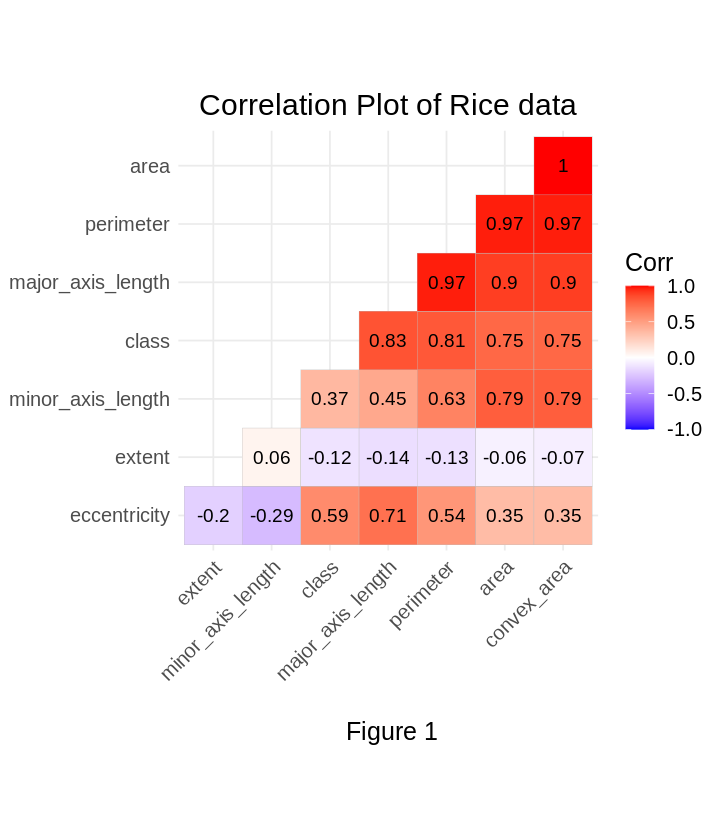

In [8]:
options(repr.plot.width = 6, repr.plot.height = 7)

#Converting Data set into binary class variable and correct vectors for Corr plot
binary_data <- rice_data |>
     mutate(class = ifelse(class == "Cammeo",1,0)) |>
     cor(use="complete.obs") 

#Plotting Corr plot
ggcorrplot(binary_data, 
           hc.order = TRUE, 
           type = "lower",
           lab = TRUE) +

labs(title = "Correlation Plot of Rice data",
     caption = "\n Figure 1") +

theme(text = element_text(size = 15),
      plot.title = element_text(hjust = 0.5),
      plot.caption = element_text(size = 15, hjust = 0.5))

*Figure 1.0* indicates that the `major_axis_length` and the `perimeter` are have the highest correlation with `class`. Thus we will analyze these variables to determine if different properties between Cammeo and Osmancik Rice.


In [1]:
cleaned_rice_data <- rice_data|>
                     select(perimeter, major_axis_length, class) #selected our variables of interest
head(cleaned_rice_data) 

ERROR: Error in select(rice_data, perimeter, major_axis_length, class): could not find function "select"


 To further analyze this correlation, we will plot the side-by-side boxplots for each of our variables of interest. 

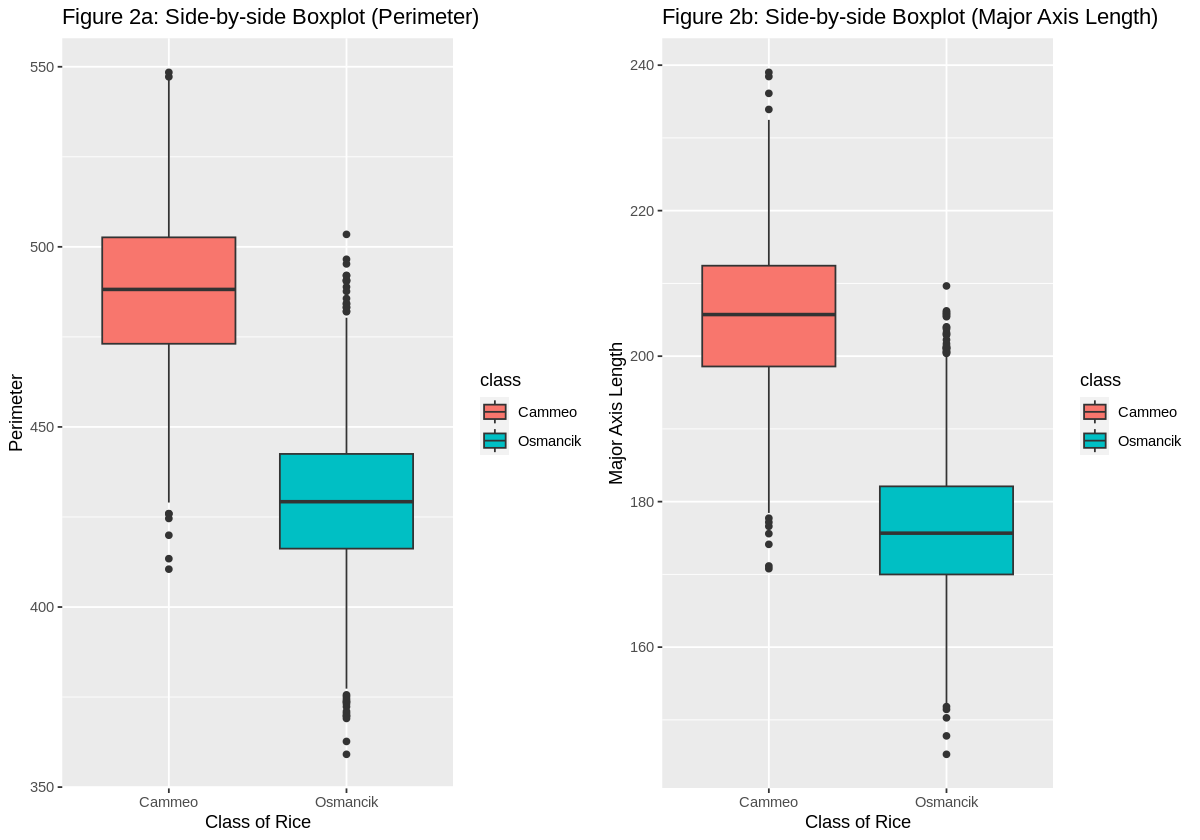

In [45]:
options(repr.plot.width = 10, repr.plot.height = 7)

#Plotting major_axis_length vs class box plot
mal_plot <- ggplot(cleaned_rice_data, aes(x = class, y = major_axis_length)) +  
    geom_boxplot(aes(fill = class)) +
    xlab("Class of Rice") +
    ylab("Major Axis Length") +
    ggtitle("Figure 2b: Side-by-side Boxplot (Major Axis Length)")

#Plotting perimeter vs class boxplot
peri_plot <- ggplot(cleaned_rice_data, aes(x = class, y = perimeter)) +
    geom_boxplot(aes(fill = class)) +
    xlab("Class of Rice") +
    ylab("Perimeter") +
    ggtitle("Figure 2a: Side-by-side Boxplot (Perimeter)")

#Arranges the plots in a neater format
grid.arrange(peri_plot, mal_plot, ncol = 2)

From our boxplots in Figure 1.2 (a) and (b), it can be inferred that the mean Cammeo rice has a larger perimeter and major axis length than Osmancik. However, to explore this quantitatively, we will do hypothesis testing. But first, we will calculate the data parameter estimates from our sample

### 2.3.1 Data Parameter Estimates

In [44]:
# Calculating the mean and standard deviation for each selected class
summary_rice <- cleaned_rice_data |>
    group_by(class) |>
    summarize(mean_perimeter = mean(perimeter), mean_mal = mean(major_axis_length), 
              sd_perimeter = sd(perimeter), sd_mal = sd(major_axis_length))

# Calculating the parameters of interest: difference in means and difference in standard deivation for the perimeter
# major axis length
rice_estimates <- summary_rice %>%
    pivot_wider(names_from = class, values_from = c(mean_perimeter, mean_mal, sd_perimeter, sd_mal)) |>
    mutate(mean_diff_perimeter = mean_perimeter_Cammeo - mean_perimeter_Osmancik,
           mean_diff_mal = mean_mal_Cammeo - mean_mal_Osmancik,
           sd_diff_perimeter = sd_perimeter_Cammeo - sd_perimeter_Osmancik,
           sd_diff_mal = sd_mal_Cammeo - sd_mal_Osmancik) |>
    select(mean_diff_perimeter, mean_diff_mal, sd_diff_perimeter, sd_diff_mal)

# listing the estimates
summary_rice
rice_estimates

class,mean_perimeter,mean_mal,sd_perimeter,sd_mal
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Cammeo,487.4389,205.4786,22.18152,10.333854
Osmancik,429.4155,176.2878,20.15439,9.362405


mean_diff_perimeter,mean_diff_mal,sd_diff_perimeter,sd_diff_mal
<dbl>,<dbl>,<dbl>,<dbl>
58.02344,29.19083,2.027124,0.9714491


## 3. Methods: Plan


## References
- Rice (Cammeo and Osmancik). (2019). UCI Machine Learning Repository. https://doi.org/10.24432/C5MW4Z.

- [Koklu, M., Cinar, I., & Taspinar, Y. S. (2021). Classification of rice varieties with deep learning methods. Computers and Electronics in Agriculture, 187, 106285. https://doi.org/10.1016/j.compag.2021.106285](https://www.sciencedirect.com/science/article/pii/S0168169921003021)
- [Tuğrul, B. (2022). Classification of five different rice seeds grown in Turkey with deep learning methods . Communications Faculty of Sciences University of Ankara Series A2-A3 Physical Sciences and Engineering , 64 (1) , 40-50 . DOI: 10.33769/aupse.1107590](https://dergipark.org.tr/en/pub/aupse/issue/68241/1107590)